<a href="https://colab.research.google.com/github/harshvs4/EVA/blob/main/PyTorch2_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing Libraries**

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, TensorDataset
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np

import random

In [31]:
# check if cuda is available
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)

## **Creating DataSet**

In [67]:
#Creating Dataset

class MNISTdatasetRandomNumber(Dataset):
  def __init__(self, MNISTDataset):
    self.MNISTDataset = MNISTDataset

  def __getitem__(self, index):
    image = self.MNISTDataset[index][0]
    label = self.MNISTDataset[index][1]
    randomNo = random.randint(0, 9)
    oneHotRandomNo = torch.nn.functional.one_hot(torch.arange(0, 10))
    sum = label + randomNo
    return image, label, oneHotRandomNo[randomNo], sum
  
  def __len__(self):
    return len(self.MNISTDataset)

In [5]:
#torch.nn.functional.one_hot(torch.arange(0, 10))

In [68]:
# torchvision.datasets.MNIST outputs a set of PIL images
# We transform them to tensors
transform = transforms.ToTensor()

# Load and transform data
MNIST_train = torchvision.datasets.MNIST('./tmp', train=True, download=True, transform=transform)
MNIST_trainset, MNIST_valset = torch.utils.data.random_split(MNIST_train, [55000, 5000])
MNIST_testset = torchvision.datasets.MNIST('./tmp', train=False, download=True, transform=transform)

In [69]:
train_dataset = MNISTdatasetRandomNumber(MNIST_trainset)
val_dataset = MNISTdatasetRandomNumber(MNIST_valset)
test_dataset = MNISTdatasetRandomNumber(MNIST_testset)

In [70]:
train_loader = DataLoader(train_dataset,batch_size=128,shuffle=True)
val_loader = DataLoader(val_dataset,batch_size=128)
test_loader = DataLoader(test_dataset,batch_size=128)

In [72]:
dataiter = iter(train_loader)
image, label, randomNo, sum = next(dataiter)

print('Images: ', image.shape)
print('Labels: ', label.shape)
print('Random Numbers: ', randomNo.shape)
print('Sum: ', sum.shape)


#print('Images: ', image)
print('Labels: ', label)
print('Random Numbers: ', randomNo)
print('Sum: ', sum)


Images:  torch.Size([128, 1, 28, 28])
Labels:  torch.Size([128])
Random Numbers:  torch.Size([128, 10])
Sum:  torch.Size([128])
Labels:  tensor([8, 2, 3, 4, 6, 2, 7, 1, 1, 3, 1, 9, 5, 6, 6, 1, 9, 1, 9, 6, 1, 1, 1, 9,
        8, 2, 1, 9, 4, 3, 7, 6, 8, 9, 1, 2, 1, 3, 1, 8, 1, 5, 8, 3, 7, 0, 9, 0,
        9, 0, 4, 7, 2, 7, 2, 8, 2, 7, 7, 0, 3, 8, 5, 6, 8, 2, 8, 5, 9, 8, 7, 5,
        9, 6, 6, 5, 8, 9, 6, 6, 8, 5, 4, 6, 3, 5, 0, 0, 2, 1, 7, 3, 2, 3, 7, 2,
        8, 0, 5, 0, 9, 0, 8, 1, 6, 1, 8, 3, 6, 0, 7, 7, 2, 0, 6, 5, 8, 9, 3, 2,
        4, 6, 2, 5, 8, 9, 2, 4])
Random Numbers:  tensor([[0, 1, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 1, 0, 0],
        ...,
        [1, 0, 0,  ..., 0, 0, 0],
        [0, 1, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0]])
Sum:  tensor([ 9,  8, 10,  8, 15,  9, 15,  4,  4,  5,  8, 12,  5, 10, 10,  3, 16,  9,
        15,  7, 10,  6,  7, 14, 14,  3,  5, 11, 11, 10,  8,  9, 15,  9, 10,  7,
         2,  5,  5, 13,  3, 1

In [43]:
#next(iter(train_loader))

## **Defining Network**

In [78]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)       #Input: 28*28*1    Output:28 * 28 * 32    GRF:3 * 3  (GRF - Global Receptive Field)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)      #Input: 28*28*32   Output:28 * 28 * 64    GRF:5 * 5
        self.pool1 = nn.MaxPool2d(2, 2)                   #Input: 28*28*64   Output:14 * 14 * 64    GRF:10*10 (for now we are considering that with max pooling, receptive field doubles - but this is not entirely correct)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)     #Input: 14*14*64   Output:14 * 14 * 128   GRF:12*12
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)    #Input: 14*14*128  Output:14 * 14 * 256   GRF:14*14
        self.pool2 = nn.MaxPool2d(2, 2)                   #Input: 14*14*256  Output: 7 * 7 * 256    GRF:28*28
        self.conv5 = nn.Conv2d(256, 512, 3)               #Input: 7*7*256    Output: 5 * 5 * 12     GRF:30*30
        self.conv6 = nn.Conv2d(512, 1024, 3)              #Input: 5*5*12     Output: 3 * 3 * 1024   GRF:32*32
        self.conv7 = nn.Conv2d(1024, 10, 3)               #Input: 3*3*1024   Output: 1 * 1 * 10     GRF:34*34


        self.fc1 = nn.Linear(10+10, 128)                  #Concatenate two inputs 
        # self.fc2 = nn.Linear(128, 30)
        self.fc2 = nn.Linear(128, 19)

    def forward(self, image, randomNumber):
        #The first convolutional layer self.conv1 has a convolutional operation on input tensor x, followed by a relu activation operation 
        #whcih is then passed to second convolution operation self.conv2 followed by a relu whose output is then passed to a max pooling 
        x = self.pool1(F.relu(self.conv2(F.relu(self.conv1(image)))))

        #The output of the max pool operation is passed to another two convolution and relu activation operation followed by max pooling. 
        #The relu() and the max_pool2d() calls are just pure operations. Neither of these have weights  
        x = self.pool2(F.relu(self.conv4(F.relu(self.conv3(x)))))

        #The output of the max pool operation from 4th convolution is passed to another two sets of convolution and relu activation operation
        x = F.relu(self.conv6(F.relu(self.conv5(x))))

        # The output from 6th convolution is then passed to a linear layer
        x = self.conv7(x)  

        #The flatten's all of the tensor's elements into a single dimension.
        x = x.view(-1, 10)
        
        #concatenate second input to the output from above convolution
        x1 = torch.cat((x, randomNumber), dim=1)
        
        # Further train the network on Dense Layer
        x1 = F.relu(self.fc1(x1))
        #x1 = F.relu(self.fc2(x1))    
        x1 = self.fc2(x1)  

        # Inside the network we usually use relu() as our non-linear activation function, but for the output layer, we use Softmax function for predicting category with maximum probability. 
        #The softmax function returns a positive probability for each of the prediction classes, and the values sum to 1.

        #Model returns two outputs:
          #Output1 : "number" represented by the MNIST image 
          #Output2 : "sum" of this number with the random number that was generated

        return F.log_softmax(x, dim = 1), F.log_softmax(x1, dim = 1)

In [79]:
!pip install torchsummary
from torchsummary import summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [80]:
print(model)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (conv6): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1))
  (conv7): Conv2d(1024, 10, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=20, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=19, bias=True)
)


## **Training phase**

In [59]:
len(train_loader)

430

In [81]:
def train(model, device, train_loader, optimizer, epoch):
    # set the model in training model
    model.train()

    epoch_loss = 0

    # run for all the data in train_loader
    for batch_idx, (data, target, random_number, sum) in enumerate(train_loader):

        # fetch the data and the target values
        target = target.type(torch.LongTensor)
        sum = sum.type(torch.LongTensor)

        # move the data to device
        data, target, sum = data.to(device), target.to(device), sum.to(device)

        # zero out the gradients
        optimizer.zero_grad()

        # forward pass the model with the data
        output, sum_output = model(data,random_number.to(device))

        # compute the loss occured
        mnist_loss = F.nll_loss(output, target)
        addition_loss = F.nll_loss(sum_output, sum)
        loss= (mnist_loss + addition_loss)/2

        epoch_loss += loss.item()

        # compute the backward gradients
        loss.backward()

        # update the optimizer params
        optimizer.step()
    print('Train set: Average loss: {:.4f}'.format(loss.item()))

    train_loss = epoch_loss / len(train_loader)
    return train_loss


## **Testing phase**

In [82]:
def test(model, device, test_loader,test_type='Val'):
    # set the model in evaluation model
    model.eval()

    # set the loss to zero
    test_loss = 0
    
    # the number of correct classifications
    correct_mnist = 0
    correct_addition = 0

    # turn off gradients during the testing
    with torch.no_grad():
        for (data, target, random_number, sum) in test_loader:

            # move the data to device
            target = target.type(torch.LongTensor)
            sum = sum.type(torch.LongTensor)
            data, target,sum = data.to(device), target.to(device), sum.to(device)

            # forward pass the model and get the output
            output, sum_output = model(data,random_number.to(device))

            # accumulate the loss from both the network outputs
            test_loss += (F.nll_loss(output, target, reduction='sum').item() + F.nll_loss(sum_output, sum, reduction='sum').item())/2

            # get the index of max log-probability
            mnist_pred = output.argmax(dim=1, keepdim=True)
            addition_pred = sum_output.argmax(dim=1, keepdim=True)

            # increment the correct prediction count if pred is correct
            correct_mnist += mnist_pred.eq(target.view_as(mnist_pred)).sum().item()
            correct_addition += addition_pred.eq(sum.view_as(addition_pred)).sum().item()


    # test loss divided by the total number of items in test dataset
    test_loss /= len(test_loader.dataset)
    print(f'{test_type} set: Average loss: {test_loss:.3f}, MNist Accuracy:{100. * correct_mnist/len(test_loader.dataset)}, Sum_Accuracy:{100. * correct_addition/len(test_loader.dataset)}')

    return test_loss


## **Testing and Training the model**

In [83]:
# move the model to the specified device
model = Net().to(device)

# use Stochastic Gradient Descent as the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.7)

# set the number of epochs to train for
num_epoch = 20

train_loss_values = []
valid_loss_values = []

# run it for epoch number of times
for epoch in range(1, num_epoch+1):
    print('\nEpoch {} : '.format(epoch))
    # train the model
    train_loss = train(model, device, train_loader, optimizer, epoch)
    valid_loss = test(model, device, val_loader)
    # test the model

    train_loss_values.append(train_loss)
    valid_loss_values.append(valid_loss)


Epoch 1 : 
Train set: Average loss: 1.9467
Val set: Average loss: 1.929, MNist Accuracy:72.58, Sum_Accuracy:10.28

Epoch 2 : 
Train set: Average loss: 1.2593
Val set: Average loss: 1.322, MNist Accuracy:93.14, Sum_Accuracy:13.06

Epoch 3 : 
Train set: Average loss: 1.1784
Val set: Average loss: 1.227, MNist Accuracy:95.52, Sum_Accuracy:17.94

Epoch 4 : 
Train set: Average loss: 1.1803
Val set: Average loss: 1.171, MNist Accuracy:96.42, Sum_Accuracy:23.24

Epoch 5 : 
Train set: Average loss: 1.1230
Val set: Average loss: 1.110, MNist Accuracy:97.2, Sum_Accuracy:32.88

Epoch 6 : 
Train set: Average loss: 1.0567
Val set: Average loss: 1.046, MNist Accuracy:97.6, Sum_Accuracy:39.76

Epoch 7 : 
Train set: Average loss: 0.9498
Val set: Average loss: 0.971, MNist Accuracy:97.96, Sum_Accuracy:49.22

Epoch 8 : 
Train set: Average loss: 0.9162
Val set: Average loss: 0.892, MNist Accuracy:98.14, Sum_Accuracy:59.82

Epoch 9 : 
Train set: Average loss: 0.8019
Val set: Average loss: 0.815, MNist Ac

## **Visualization**

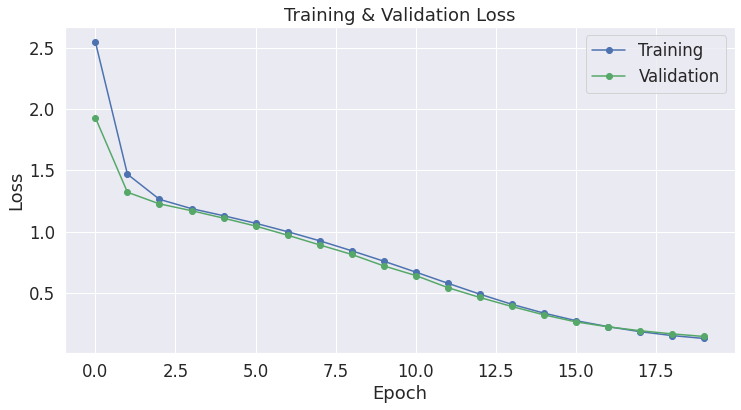

In [85]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(np.array(train_loss_values), 'b-o', label="Training")
plt.plot(np.array(valid_loss_values), 'g-o', label="Validation")


# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [86]:
def prediction(image,rnum):

    rnum_ohe = torch.zeros(11).long()
    rnum_ohe[rnum] = 1
    rnum_ohe = rnum_ohe[:-1]

    #tensored_image = image.unsqueeze(dim=1).to(device)
    output_1,output_2 = model(image.unsqueeze(dim=1).to(device),rnum_ohe.reshape(-1,10).to(device))

    mnist_pred = output_1.argmax(dim=1, keepdim=True)
    sum_pred = output_2.argmax(dim=1, keepdim=True)

    #print(f"Random Number Generated is {rnum}")
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(3, 3, 1)
    ax.axis('off')
    ax.imshow(image.cpu().numpy().squeeze())
    ax.set_title(f'Random Number Generated : {rnum} \n'
                 f'Mnist Prediction: {mnist_pred.item()} \n'
                 f'Sum: {rnum} + {mnist_pred.item()} = {sum_pred.item()}')
    return mnist_pred, sum_pred

## **Prediction**

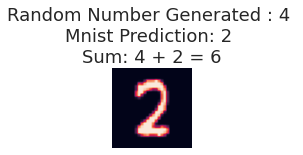

In [88]:
image,_,_,_ = test_dataset[random.randint(1,10000)]
rnum=random.randint(0,9)
mnist_pred, sum_pred =prediction(image,rnum)

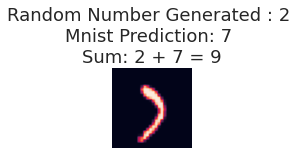

In [89]:
image,_,_,_ = test_dataset[random.randint(1,10000)]
rnum=random.randint(0,9)
mnist_pred, sum_pred =prediction(image,rnum)

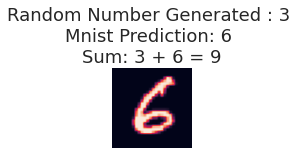

In [90]:
image,_,_,_ = test_dataset[random.randint(1,10000)]
rnum=random.randint(0,9)
mnist_pred, sum_pred =prediction(image,rnum)